# load data

In [ ]:
from google.colab import files
files.upload()  # ← ارفعي ملف kaggle.json هنا


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alaashorbaji","key":"b2fda0b970946bc21efe74c1b48e4a3d"}'}

In [ ]:
!pip install -q kaggle

# إعداد صلاحيات kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# تنزيل البيانات
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp
!unzip -q emotions-dataset-for-nlp.zip -d emotions_data


Dataset URL: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
License(s): CC-BY-SA-4.0
  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 1.12GB/s]


In [ ]:
import pandas as pd

# تحميل بيانات التدريب والاختبار
train_df = pd.read_csv("emotions_data/train.txt", sep=';', names=["text", "label"])
test_df = pd.read_csv("emotions_data/test.txt", sep=';', names=["text", "label"])

# عرض أول صفوف
train_df.head()


# Preview the Emotion Detection Dataset

In [ ]:
import pandas as pd

# Load training and test datasets from text files
train_df = pd.read_csv("/content/emotions_data/train.txt", sep=';', names=["text", "label"])
test_df = pd.read_csv("/content/emotions_data/test.txt", sep=';', names=["text", "label"])

# Display the first few rows of the training data
train_df.head()


,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Visualize class distribution

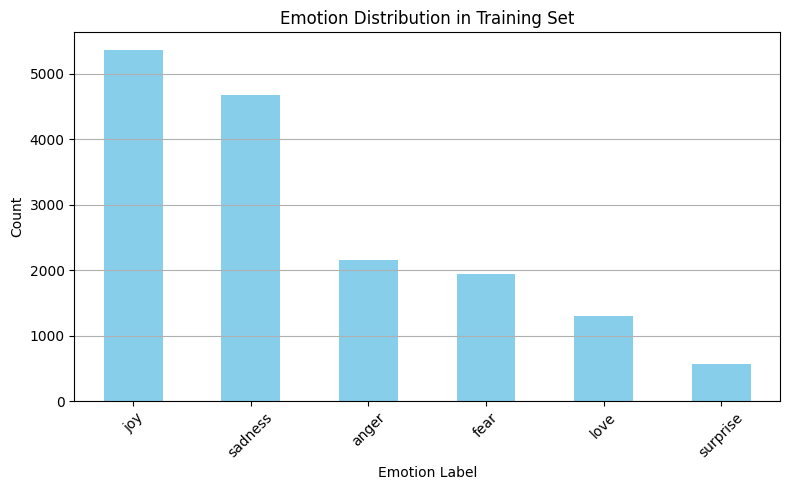

In [ ]:
import matplotlib.pyplot as plt

# Count of each emotion label
label_counts = train_df['label'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Emotion Distribution in Training Set")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Convert DataFrame to Hugging Face Dataset

In [ ]:
from datasets import Dataset, DatasetDict

# Convert pandas DataFrames to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# Create a DatasetDict to organize train/test
dataset = DatasetDict({
    "train": train_ds,
    "test": test_ds
})

# Preview sample
dataset["train"][0]


{'text': 'i didnt feel humiliated', 'label': 'sadness'}

# Tokenize the Text Using DistilBERT Tokenizer

In [ ]:
from transformers import AutoTokenizer

# Load DistilBERT tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Define a tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

# Apply the tokenizer to the dataset
tokenized_dataset = dataset.map(tokenize_function)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Encode Labels to Integers

In [ ]:
# Get the unique list of labels from training data
label_list = train_df["label"].unique().tolist()

# Create label2id and id2label mappings
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}

# Encode the labels using the mapping
def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

# Apply label encoding to the dataset
tokenized_dataset = tokenized_dataset.map(encode_labels)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Fine-Tuning DistilBERT using Trainer API

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load DistilBERT model for classification
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
import evaluate
import numpy as np

# Load accuracy metric
accuracy = evaluate.load("accuracy")

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


In [ ]:
!pip install --upgrade --quiet transformers==4.38.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 99.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.38.2 which is incompatible.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="emotion_model",
    do_train=True,
    do_eval=True,
    report_to="none",  # ⛔ Disable wandb & other logging tools
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="logs"
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-24-669581489.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.727000
1000,0.247200
1500,0.154700
2000,0.148500
2500,0.108800
3000,0.105000
3500,0.079400
4000,0.072700


TrainOutput(global_step=4000, training_loss=0.2054032735824585, metrics={'train_runtime': 200.1276, 'train_samples_per_second': 319.796, 'train_steps_per_second': 19.987, 'total_flos': 2119629570048000.0, 'train_loss': 0.2054032735824585, 'epoch': 4.0})

In [ ]:
import torch

# Automatically detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to device

def predict_emotion(text):
    # Tokenize and move input to the same device as the model
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

    # Forward pass without gradient tracking
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class
    predicted_label_id = torch.argmax(outputs.logits, dim=1).item()
    return id2label[predicted_label_id]

# Try predictions again
examples = [
    "I am so happy today!",
    "I feel terrible and hopeless.",
    "This is absolutely amazing!",
    "I’m scared of what will happen tomorrow.",
    "I love being around my friends."
]

for text in examples:
    print(f"Text: {text}\n→ Predicted Emotion: {predict_emotion(text)}\n")


Text: I am so happy today!
→ Predicted Emotion: joy

Text: I feel terrible and hopeless.
→ Predicted Emotion: sadness

Text: This is absolutely amazing!
→ Predicted Emotion: surprise

Text: I’m scared of what will happen tomorrow.
→ Predicted Emotion: fear

Text: I love being around my friends.
→ Predicted Emotion: anger

